In [1]:
import networkx as nx
import numpy as np
import random
random.seed;
import matplotlib.pyplot as plt
import scipy
from scipy import sparse
from scipy.sparse import linalg
import time
import math
from scipy import stats
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from random import shuffle
import matplotlib

import sys
sys.path += ['/Package']  ### Specify the directory where the Package is
from clustering import *


import warnings
warnings.filterwarnings("ignore")

In [2]:
n = 500 #  number of nodes
n_average = 10 # number of average
fraction = int(n/2) # number of nodes in the first family
number_sim = 15 # number of points where to do the simulation

classes = np.zeros(n)
classes[:fraction] = 1
n_param = 15

##### create the c_in and c_out vectors ########

c_out = 1
c_in = 15
c_in_v = np.zeros(number_sim)
c_out_v = np.zeros(number_sim)
for i in range(number_sim):
    c_in_v[i] = c_in - i/2.5
    c_out_v[i] = c_out + i/2.5
    

    
###############################################  
    

### These are the various distributions of theta used
    

'''In the following three cases we create two ordered vectors of size n/2 that are equally placed in the two classes.
By decommenting the command random.shuffle(theta) this can be used to see the action of the degree on the variance'''


theta = np.random.uniform(3,10,size = n)**4
theta = theta/np.mean(theta)
assortativity = 1
phi = np.mean(theta**2)
c = (c_in_v + c_out_v)[0]/2
r_v = np.logspace(0,math.log10(c*phi),n_param)  

## Simulation

In [8]:
t0 = time.time()
mean_new = np.zeros((n_param+3, number_sim))
mean_old = np.zeros((n_param+3, number_sim))
M = np.zeros((n_param+3, number_sim))

for i in range(number_sim):
    for k in range(n_average):
        
        c_in = c_in_v[i]
        c_out = c_out_v[i]

        A = adj(c_in,c_out,theta,fraction) # create the adjacency matrix
        d = np.sum(A.astype(float),axis = 0) # degree vector
        phi = np.mean(theta**2) # second moment of the theta vector 
        
        r = (c_in + c_out)/(c_in - c_out) # our choice of r
        c = (c_in + c_out)/2 # average degree
        predict, eigenvalues, X, ov = BH(A, classes,r,assortativity) # our proposed method D - zetaA
        
        mean_new[0][i] = (mean_old[0][i]*k + ov)/(k+1)
        M[0][i] +=  (ov - mean_new[0][i])*(ov - mean_old[0][i])
        mean_old[0][i] = mean_new[0][i]
        
        r = (c_in - c_out)/2*phi 
        predict, eigenvalues, X, ov = BH(A, classes,r,assortativity) # our proposed method D - zetaA
        
        mean_new[1][i] = (mean_old[1][i]*k + ov)/(k+1)
        M[1][i] += (ov - mean_new[1][i])*(ov - mean_old[1][i])
        mean_old[1][i] = mean_new[1][i]
        
        r = np.sqrt(c)
        predict, eigenvalues, X, ov = BH(A, classes,r,assortativity) # our proposed method D - zetaA
        
        mean_new[2][i] = (mean_old[2][i]*k + ov)/(k+1)
        M[2][i] += (ov - mean_new[2][i])*(ov - mean_old[2][i])
        mean_old[2][i] = mean_new[2][i]    
        
        
        for p in range(n_param):
            
            r = r_v[p]
            predict, eigenvalues, X, ov = BH(A, classes,r,assortativity)
            
            mean_new[p+3][i] = (mean_old[p+3][i]*k + ov)/(k+1)
            M[p+3][i] += (ov - mean_new[p+3][i])*(ov - mean_old[p+3][i])
            mean_old[p+3][i] = mean_new[p+3][i]

        
        OUT = 'Completion : i = ' + str(i+1) + '/'+str(number_sim) + ', j = ' + str(k+1) + ' Time : ' + str(time.time()-t0)
        sys.stdout.write('\r%s' % OUT)
        sys.stdout.flush()

        


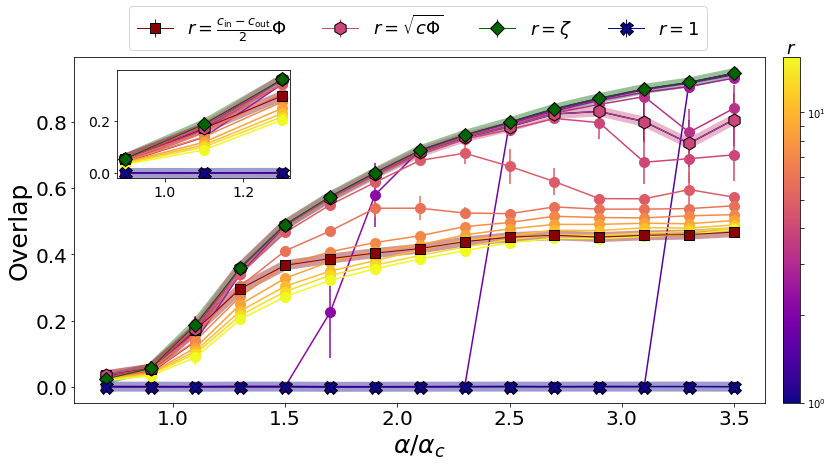

In [7]:
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax2 = fig.add_axes([0.15, 0.62, 0.20, 0.25])

alpha = (c_in_v - c_out_v)/np.sqrt(c)
Phi = np.mean(theta**2)
alpha_c = 2/np.sqrt(2)
c_m = matplotlib.cm.plasma
norm = matplotlib.colors.LogNorm(vmin=min(r_v),vmax=max(r_v))
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm = norm)
s_m.set_array([])
for p in range(n_param):
    ax1.errorbar(alpha/alpha_c,mean_new[p+2],yerr = np.sqrt(M[p+2]/n_average)/2,marker = 'o',color = s_m.to_rgba(r_v[p]),markersize = 10,markeredgecolor =  s_m.to_rgba(r_v[p]))
# cbar = plt.colorbar(s_m)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
fig.colorbar(s_m, cax=cbar_ax)
cbar_ax.set_ylabel(r'$r$', labelpad=-35, y=1.05, rotation=0, fontsize = 18)

ax1.plot(alpha/alpha_c,mean_new[0], color = 'darkgreen',linewidth = 10, alpha = 0.4)
ax1.plot(alpha/alpha_c,mean_new[1], color = 'darkred',linewidth = 10, alpha = 0.4)
ax1.plot(alpha/alpha_c,mean_new[2], color = s_m.to_rgba(np.sqrt(c*Phi)),linewidth = 10, alpha = 0.4)
ax1.plot(alpha/alpha_c,mean_new[3], color = s_m.to_rgba(1),linewidth = 10, alpha = 0.4)

ax1.errorbar(alpha/alpha_c,mean_new[1],yerr = np.sqrt(M[1]/n_average)/2, marker = 's',color = 'darkred',linewidth = 1, label = r'$r = \frac{c_{\rm in} - c_{\rm out}}{2}\Phi$',markersize = 10, markeredgecolor = 'k')
ax1.errorbar(alpha/alpha_c,mean_new[2],yerr = np.sqrt(M[2]/n_average)/2, marker = 'h',color = s_m.to_rgba(np.sqrt(c*Phi)),linewidth = 1, label = r'$r = \sqrt{c\Phi}$',markersize = 13, markeredgecolor = 'k')
ax1.errorbar(alpha/alpha_c,mean_new[0],yerr = np.sqrt(M[0]/n_average)/2, marker = 'D',color = 'darkgreen',linewidth = 1, label = r'$r = \zeta$',markersize = 10, markeredgecolor = 'k')
ax1.errorbar(alpha/alpha_c,mean_new[3],yerr = np.sqrt(M[3]/n_average)/2, marker = 'X',color = s_m.to_rgba(1),linewidth = 1, label = r'$r = 1$',markersize = 13, markeredgecolor = 'k')
ax1.legend(fontsize = 18, ncol = 4,bbox_to_anchor=(0.08,1.02),loc="lower left", borderaxespad=0)

# ax1.axvline(1, color = 'k', linestyle = '-.', linewidth = 1)

fs = 20
ax1.tick_params(axis="x", labelsize=fs)
ax1.tick_params(axis="y", labelsize=fs)
ax1.set_xlabel(r'$\alpha/\alpha_c$',fontsize = 25)
ax1.set_ylabel('Overlap',fontsize = 25)


for p in range(n_param):
    ax2.errorbar(alpha[number_sim-4:number_sim-1]/alpha_c,mean_new[p+2][number_sim-4:number_sim-1],yerr = np.sqrt(M[p+2][number_sim-4:number_sim-1]/n_average)/2,marker = 'o',color = s_m.to_rgba(r_v[p]),markersize = 10,markeredgecolor =  s_m.to_rgba(r_v[p]))

ax2.errorbar(alpha[number_sim-4:number_sim-1]/alpha_c,mean_new[1][number_sim-4:number_sim-1],yerr = np.sqrt(M[1][number_sim-4:number_sim-1]/n_average)/2, marker = 's',color = 'darkred',linewidth = 1, label = r'$r = \frac{c_{\rm in} - c_{\rm out}}{2}\Phi$',markersize = 10, markeredgecolor = 'k')
ax2.errorbar(alpha[number_sim-4:number_sim-1]/alpha_c,mean_new[2][number_sim-4:number_sim-1],yerr = np.sqrt(M[2][number_sim-4:number_sim-1]/n_average)/2, marker = 'h',color = s_m.to_rgba(np.sqrt(c*Phi)),linewidth = 1, label = r'$r = \sqrt{c\Phi}$',markersize = 13, markeredgecolor = 'k')
ax2.errorbar(alpha[number_sim-4:number_sim-1]/alpha_c,mean_new[0][number_sim-4:number_sim-1],yerr = np.sqrt(M[0][number_sim-4:number_sim-1]/n_average)/2, marker = 'D',color = 'darkgreen',linewidth = 1, label = r'$r = \zeta$',markersize = 10, markeredgecolor = 'k')
ax2.errorbar(alpha[number_sim-4:number_sim-1]/alpha_c,mean_new[3][number_sim-4:number_sim-1],yerr = np.sqrt(M[3][number_sim-4:number_sim-1]/n_average)/2, marker = 'X',color = s_m.to_rgba(1),linewidth = 1, label = r'$r = 1$',markersize = 13, markeredgecolor = 'k')

ax2.plot(alpha[number_sim-4:number_sim-1]/alpha_c,mean_new[0][number_sim-4:number_sim-1], color = 'darkgreen',linewidth = 10, alpha = 0.4)
ax2.plot(alpha[number_sim-4:number_sim-1]/alpha_c,mean_new[1][number_sim-4:number_sim-1], color = 'darkred',linewidth = 10, alpha = 0.4)
ax2.plot(alpha[number_sim-4:number_sim-1]/alpha_c,mean_new[2][number_sim-4:number_sim-1], color = s_m.to_rgba(np.sqrt(c*Phi)),linewidth = 10, alpha = 0.4)
ax2.plot(alpha[number_sim-4:number_sim-1]/alpha_c,mean_new[3][number_sim-4:number_sim-1], color = s_m.to_rgba(1),linewidth = 10, alpha = 0.4)


fs2 = 14

ax2.tick_params(axis="x", labelsize=fs2)
ax2.tick_params(axis="y", labelsize=fs2)

plt.show();